<a href="https://colab.research.google.com/github/marsonnatalia/teste/blob/main/Series_Sinteticas_Natalia_Marson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
!pip install PySDDP

In [125]:
from google.colab import drive, files
import os

#Montar o Google Drive no Colab com o nome gdrive

drive.mount('/content/gdrive')

# O comando abaixo mostra qual diretório você está trabalhando momento.
print( os.getcwd() )

Caminho_do_Arquivo = 'gdrive/My Drive/Newave_Ago_2023/'
# O comando mostra o que está presente dentro da minha pasta GIF no meu drive, que está dentro do meu drive e em Doutorado. Mudar para o diretório que vocês criaram.
print( os.listdir(Caminho_do_Arquivo) )

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content
['PATAMAR.DAT', 'NewaveMsgPortug.txt', 'MANUTT.DAT', 'HIDR.DAT', 'MODIF.DAT', 'LOSS.DAT', 'MENSAG.TMP', 'ITAIPU.DAT', 'GTMINPAT.DAT', 'GTMIN_CCEE_082023.xlsx', 'GHMIN.DAT', 'FORMAT.TMP', 'EXPH.DAT', 'EXPT.DAT', 'ENSOAUX.DAT', 'ELNINO.DAT', 'CVAR.DAT', 'C_ADIC.DAT', 'DGER.DAT', 'DSVAGUA.DAT', 'CURVA.DAT', 'CONFT.DAT', 'CDEFVAR.DAT', 'AGRINT.DAT', 'ARQUIVOS.DAT', 'ADTERM.DAT', 'CASO.DAT', 'CLAST.DAT', 'BID.DAT', 'VAZOES.DAT', 'CONFHD.DAT', 'VAZPAST.DAT', 'REE.DAT', 'RE.DAT', 'TERM.DAT', 'PENALID.DAT', 'tecno.dat', 'SHIST.DAT', 'selcor.dat', 'POSTOS.DAT', 'SISTEMA.DAT']


In [126]:
from PySDDP.Pen import Newave

PMOAGO2023 = Newave(Caminho_do_Arquivo)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


In [127]:
usina_srt = input('Digite o nome da Unisa a ser analisada: ')
USINA = usina_srt
Usina = PMOAGO2023.confhd.get(USINA)

Digite o nome da Unisa a ser analisada: FURNAS


## Otimização para Estimar a Vazão de um Mês

$$Min \sum_{i=1931}^{2021}erro^2_{i}$$

s. a:

$$ Z_{AGO1931}=\phi_1 \cdot Z_{MAI,1931} + \phi_2 \cdot Z_{JUN,1931} + \phi_3 \cdot Z_{JUL,1931}$$
$$.$$
$$.$$
$$.$$
$$ Z_{AGO,2021}=\phi_1 \cdot Z_{MAI,2021} + \phi_2 \cdot Z_{JUN,2021} + \phi_3 \cdot Z_{JUL,2021}$$



In [128]:
# Modelo Auto-Regressivo

from cvxopt import matrix, solvers
import numpy as np


def entradas_vazao(Usina, Ano, num_meses, Mes,imprime = False):

    num_anos = len(Usina['vazoes']) - 3 # Anos com dados de vazões históricas
    Ano = Ano - 2023 + num_anos + 2

    if Mes - num_meses >= 0:
        recorte = Usina['vazoes'][1:num_anos+1,(Mes-num_meses):Mes]
    else:
        recorte_ano_atual = Usina['vazoes'][1:num_anos+1,0:Mes]
        recorte_ano_ant = Usina['vazoes'][0:num_anos,(Mes-num_meses):]
        recorte = np.hstack((recorte_ano_ant,recorte_ano_atual))

    identidade = np.eye(num_anos)

    Aeq = np.concatenate((recorte, identidade), axis = 1)
    Aeq = Aeq.astype('float')
    Aeq = matrix(Aeq)

    Beq = Usina['vazoes'][1:num_anos+1,Mes]
    Beq = Beq.astype('float')
    Beq = matrix(Beq)
    q = matrix(np.zeros(num_anos+num_meses))
    P = 2*np.eye(num_anos+num_meses)
    for i in range(0,num_meses):
        P[i][i] = 0
    P = matrix(P)

    A = np.vstack((-1*np.eye(num_anos+num_meses), np.eye(num_anos+num_meses)))
    A = A.astype('float')
    A = matrix(A)
    B = 99999*np.ones(((num_anos+num_meses)*2,1))
    B = B.astype('float')
    B = matrix(B)

    solvers.options['show_progress'] = False
    abstol = 1e-9
    reltol = 1e-9
    sol = solvers.qp(P, q, A, B, Aeq, Beq, abstol=abstol, reltol=reltol)

    fob = sum(sol['x'][num_meses:])

    if Mes - num_meses >= 0:

        soma = 0
        for i, v in enumerate(Usina['vazoes'][Ano,(Mes-num_meses):Mes]):
            soma += v*sol['x'][i]
    else:
        soma = 0
        for i, v in enumerate(Usina['vazoes'][Ano,0:Mes]):
            soma += v*sol['x'][i+num_meses-Mes]
        for i, v in enumerate(Usina['vazoes'][Ano-1,(Mes-num_meses):]):
            soma += v*sol['x'][i]

    if imprime:

        print(f'Vazão estimada para o mês {Mes}: {soma} hm^3')

    return [fob,soma,sol['x']]


In [129]:
from cvxopt import matrix, solvers
from matplotlib import pyplot as plt

# Ano a ser analisado
ano_str = input("Digite o ano a ser analisado: ")
AnoAnalisado  = int(ano_str)
#AnoAnalisado = 2021

# Numero de meses anteriores a serem considerados
num_meses_str = input("Digite o número de meses a ser considerado: ")
N_meses = int(num_meses_str)

# Numero do mes considerando janeiro zero
mes_str = input("Digite o número do mês a ser analisado: ")
Mes_analisado = 7

# Retira o ultimo e o primeiro ano e considera que a contagem começa em zero
N_anos = len(Usina['vazoes']) - 3

print(f'A vazão estimada é de: {entradas_vazao(Usina, AnoAnalisado, N_meses, Mes_analisado)[1]} m³/s')

resultado = []
fob = []

for i in range(0,12):
    resposta = entradas_vazao(Usina, AnoAnalisado, N_meses, i)
    resultado.append(resposta[1])

for i in range(1,12):
    resposta = entradas_vazao(Usina, AnoAnalisado, i, Mes_analisado)
    fob.append(resposta[0])


# Converte o ano para o indice da lista
AnoAnalisado = AnoAnalisado - 2023 + N_anos + 2


Digite o ano a ser analisado: 2021
Digite o número de meses a ser considerado: 12
Digite o número do mês a ser analisado: 9
A vazão estimada é de: 184.37254651253724 m³/s


## Plot das Vazões Estimadas e Reais

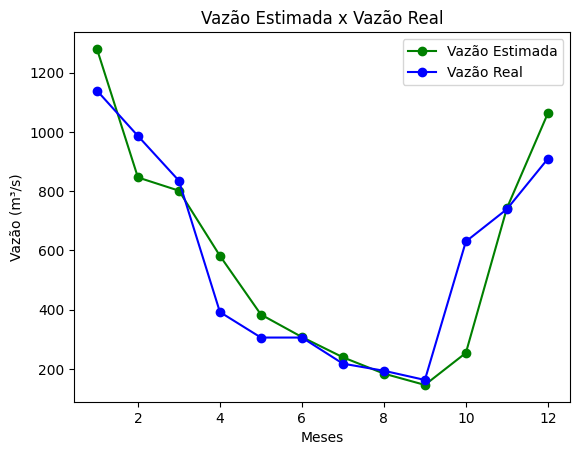

In [130]:
plt.figure()
plt.title("Vazão Estimada x Vazão Real")
plt.xlabel("Meses")
plt.ylabel("Vazão (m³/s)")
plt.plot(list(range(1,13)),resultado,marker="o",color="green",label="Vazão Estimada")
plt.plot(list(range(1,13)),Usina['vazoes'][AnoAnalisado],marker="o",color="blue",label="Vazão Real")
plt.legend()


## Plot dos Erros

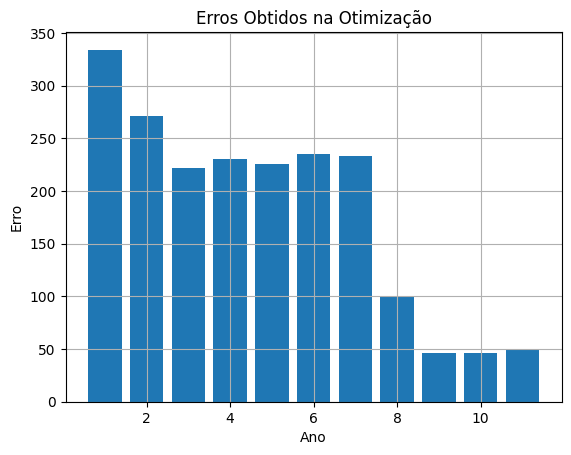

In [131]:
plt.bar(list(range(1,12)),fob)
plt.title('Erros Obtidos na Otimização')
plt.xlabel('Ano')
plt.ylabel('Erro')
plt.grid()

In [132]:
from cvxopt import matrix, solvers

def despacho(Usina, VolInicic_Perc, ano, mes, Curva_Ref, Carga, CustoForaFaixa, Saida, FlipFlop, Imprimir = False):
  produtibilidade = Usina['ro_equiv'][0][0]  # Produtibilidade em Mwmed / (m3/s)
  vazao_afluente = Usina['vazoes'][ano-1931][mes-1]
  engolimento = Usina['engol_tempo'][0][0]
  vol_max = Usina['vol_max']
  vol_min = Usina['vol_min']
  potencia = Usina['potencia_tempo'][0][0]
  VolInic_hm3 = vol_min + (vol_max-vol_min)*VolInicic_Perc/100.

  # Cálculo da Produtibilidade no Ponto
  cota = 0.
  for i in range(5):
      cota += Usina['pol_cota_vol'][i]*(VolInic_hm3**i)
  queda = cota - Usina['cfmed']
  prod_ponto = queda*Usina['prod_esp']

  produtibilidade = prod_ponto

  if Imprimir:
    print(Usina.keys())
    print(f"O a produtibilidade de Furnas é: {produtibilidade} MWmed / (m3/s) ")
    print(f"A vazao afluente de Furnas é: {vazao_afluente} m3/s")
    print(f"O engolimento máximo de Furnas é {engolimento} m3/s")
    print(f"O volume máximo de Furnas é {vol_max} hm3")
    print(f"O volume mínimo de Furnas é {vol_min} hm3")
    print(f"Potencia Nominal de Furnas é {potencia} MWmed")

  CapacidadeInstalada = potencia/0.62
  CapacidadeTermica = CapacidadeInstalada - potencia
  UTE_A = {'Nome': 'GT_A',
          'Capac': CapacidadeTermica*0.6,
          'Custo': 250.0}
  UTE_B = {'Nome': 'GT_B',
          'Capac': CapacidadeTermica*0.4,
          'Custo': 450.0}
  #CustoDeficit = 4500.
  CustoDeficit = 11000.

  Faixa_Perc =  CurvaRef['Centro'][mes-1]

  Faixa_hm3 = vol_min + (vol_max-vol_min)*Faixa_Perc/100.

  FaixaInferior = Curva_Ref['LI'][mes-1]
  FaixaSuperior = Curva_Ref['LS'][mes-1]
  FaixaInferior = vol_min + (vol_max-vol_min)*FaixaInferior/100.
  FaixaSuperior = vol_min + (vol_max-vol_min)*FaixaSuperior/100.

  Centro = Faixa_hm3

  #
  # Regra do Alberto (Centro Móvel)
  #

  CENTRO_max = VolInic_hm3 + 2.592*vazao_afluente               # – 2.592*VAZÃO MÍNIMA
  CENTRO_min = VolInic_hm3 + 2.592*vazao_afluente - engolimento

  if Faixa_hm3 > CENTRO_max:
    Centro = CENTRO_max
  if Centro < CENTRO_min:
    Centro = CENTRO_min

  P = matrix([[2.0*CustoForaFaixa/(vol_max)**2, 0.0,  0.0,  0.0,  0.0,  0.0],
              [0.0, 0.0,  0.0,  0.0,  0.0,  0.0],
              [0.0, 0.0,  0.0,  0.0,  0.0,  0.0],
              [0.0, 0.0,  0.0,  0.0,  0.0,  0.0],
              [0.0, 0.0,  0.0,  0.0,  0.0,  0.0],
              [0.0, 0.0,  0.0,  0.0,  0.0,  0.0]])

  q = matrix([-2*CustoForaFaixa*Faixa_hm3/(vol_max**2), 0.0, CustoDeficit*1.50, UTE_A['Custo'], UTE_B['Custo'], CustoDeficit])
  q = matrix([-2*CustoForaFaixa*Centro/(vol_max**2), 0.0, CustoDeficit*1.50, UTE_A['Custo'], UTE_B['Custo'], CustoDeficit])

  Aeq = matrix([[1, 2.592, 2.592, 0, 0 , 0],
              [0, produtibilidade, 0.0, 1.0, 1.0, 1.0]])

  Beq = matrix( [VolInic_hm3+2.592*vazao_afluente, Carga] )

  A = matrix( [[-1., 0., 0., 0., 0., 0.],
              [0., -1., 0., 0., 0., 0.],
              [0., 0., -1., 0., 0., 0.],
              [0., 0., 0, -1., 0., 0.],
              [0., 0., 0., 0., -1., 0.],
              [0., 0., 0., 0., 0., -1.],
              [1., 0., 0., 0., 0., 0.],
              [0., 1., 0., 0., 0., 0.],
              [0., 0., 1., 0., 0., 0.],
              [0., 0., 0., 1., 0., 0.],
              [0., 0., 0., 0., 1., 0.],
              [0., 0., 0., 0., 0., 1.]])

  Travei = False

  if Saida == None or FlipFlop == False:
    B = matrix([-vol_min, 0, 0, 0, 0, 0,
                vol_max, 1.0*engolimento, 10*vol_max, UTE_A['Capac'], UTE_B['Capac'], 10*Carga])
  else:
    Travei = True
    B = matrix([-vol_min, 0, 0, -Saida[7], -Saida[8], 0,
                vol_max, 1.0*engolimento, 10*vol_max, Saida[7], Saida[8], 10*Carga])

  solvers.options['show_progress'] = False
  abstol = 1e-9
  reltol = 1e-9

  sol = solvers.qp(P, q, A.T, B, Aeq.T, Beq, abstol=abstol, reltol=reltol)

  # x[0] -> vf (volume final - hm3)
  # x[1] -> vt (vazao turbinada - m3/s)
  # x[2] -> vv (vazao vertida - m3/s)
  # x[3] -> termica A (MWmedio)
  # x[4] -> termica B (MWmedio)
  # x[5] -> deficit (MWmedio)

  # Testar colocação do Alberto (se ficar dentro da faixa, nao tem deficit nem vertimento)

  if FlipFlop == True:
    if sol["x"][0] > FaixaSuperior or sol["x"][0] < FaixaInferior or sol["x"][2] > 0.01 or sol["x"][5] > 0.01 :
        Travei = False
        B = matrix([-vol_min, 0, 0, 0, 0, 0,
                vol_max, 1.0*engolimento, 10*vol_max, UTE_A['Capac'], UTE_B['Capac'], 10*Carga])
        sol = solvers.qp(P, q, A.T, B, Aeq.T, Beq, abstol=abstol, reltol=reltol)

  if Travei == True and FlipFlop == True:
    print (f"Geração térmica travada em {mes}/{ano}")

  if sol['status'] == 'primal infeasible':
    print(ano,'/',mes)
    print(P)
    print(q.T)
    print(A.T)
    print(B)
    print (Aeq.T)
    print (Beq)

  geracao_termica_total = sol["x"][3] + sol["x"][4] + sol["x"][5]

  # Implementar o médio ponderado (Afonso/Calobró).

  CMO = 0.
  PLD = 0.
  if geracao_termica_total > 0.001 and geracao_termica_total <= UTE_A['Capac']:
    CMO = UTE_A['Custo']
    PLD = UTE_A['Custo']
  else:
    if geracao_termica_total > 0.01 and geracao_termica_total <= UTE_A['Capac'] + UTE_B['Capac']:
      CMO = UTE_B['Custo']
      PLD = (UTE_A['Custo']*sol["x"][3] + UTE_B['Custo']*sol["x"][4])/(sol["x"][3]+sol["x"][4])
    else:
      if sol["x"][5] > 0.1:
        CMO = CustoDeficit
        PLD = (UTE_A['Custo']*sol["x"][3] +
               UTE_B['Custo']*sol["x"][4] +
               CustoDeficit*sol["x"][5])/(sol["x"][3]+sol["x"][4]+sol["x"][5])
        # Complementar depois com o acréscimo do Calobró

  if Imprimir:
    # exibir o resultado da solução
    print(f'O Volume Final ótimo é: {sol["x"][0]:.2f} hm3. Volume Inicial {VolInic_hm3} hm3. Mínimo {vol_min:.2f} hm3. Máximo {vol_max:.2f} hm3. Meta {Faixa_hm3:.2f} hm3.' )
    print(f'O volume turbinado ótimo é {sol["x"][1]:.2f} m3/s. O engolimento máximo é {engolimento:.2f}')
    print(f'O volume vertido ótimo é {sol["x"][2]:.2f} m3/s.')
    print(f'A geração térmica ótimo da UTE_A é {sol["x"][3]:.2f} MWmed. A capacidade da térmica é {UTE_A["Capac"]}')
    print(f'A geração térmica ótimo da UTE_B é {sol["x"][4]:.2f} MWmed. A capacidade da térmica é {UTE_B["Capac"]}')
    print(f'O déficit ótimo é {sol["x"][5]:.2f} MWmed.')

    print(f'O valor da FOB é de {sol["primal objective"]+Faixa_hm3**2*CustoForaFaixa}')

    DespachonoTalo = UTE_A["Custo"]*UTE_A["Capac"]+UTE_B["Custo"]*UTE_B["Capac"]
    print(f'PEN1: {CustoForaFaixa}')
    print(f'DespachonoTalo: {DespachonoTalo}')
    print(f'Relação entre PEN1 e Despacho no Talo{CustoForaFaixa/DespachonoTalo}')

    print(f'O valor da FOB é de {sol["primal objective"]}')

    # Fechamento BH
    print ("Fechamento BH")
    print ('... Vol Inicial:', VolInic_hm3)
    print ('... Vaz Afluent:', vazao_afluente*2.592)
    print ('... Vaz Turbina:', sol['x'][1]*2.592)
    print ('... Vaz Vertida:', sol['x'][2]*2.592)
    print ('... Volf. Calc :', VolInic_hm3+vazao_afluente*2.592-sol['x'][1]*2.592-sol['x'][2]*2.592)
    print ('**************')
    print ("Fechamento AD")
    print('... Ger.Hidrau:', produtibilidade*sol['x'][1])
    print('... Ger. TermA:', sol['x'][3])
    print('... Ger. TermB:', sol['x'][4])
    print('... Deficit En:', sol['x'][5])
    print('... Carga Calc:', produtibilidade*sol['x'][1]+sol['x'][3]+sol['x'][4]+sol['x'][5])
    print ('**************')

  return [ CMO, FaixaInferior, FaixaSuperior, Faixa_hm3, sol["x"][0], sol["x"][5], sol["x"][2], sol["x"][3], sol["x"][4], PLD ]